---
---

# DL Assignment Image Classification with ResNet-18

---

**Group number:** 27

**Group members:**
- Abhey Raheja : 22UCS003
- Abhinav Singh : 22UCS004
- Akhil Murarka : 22UCS009


---
---

# INTRODUCTION

This project aims to build an image classification model leveraging the ResNet-18 architecture. The model is trained and validated using a dataset consisting of **images of monkeys**, which are categorized into multiple classes. The following steps outline the core components of the project:

1. **Data Preparation**: The dataset is loaded and preprocessed using PyTorch's `torchvision` library, ensuring compatibility with the ResNet-18 model.
   
2. **Data Augmentation**: Various image transformations, such as rotation, flipping, and resizing, are applied to the training data to enhance the model's ability to generalize to unseen data.

3. **Normalization**: The training dataset's mean and standard deviation are calculated to normalize the images, ensuring the model receives data with consistent statistical properties.

4. **Model Definition**: The ResNet-18 architecture is used as the base model. The final fully connected layer is modified to output the correct number of classes for the dataset.

5. **Training**: The model is trained using mini-batch gradient descent. During training, the loss and accuracy are monitored to evaluate the model's performance over time.

6. **Evaluation**: After training, the model is evaluated on the test dataset to measure its classification accuracy and determine its effectiveness in predicting the correct labels.

7. **Checkpointing**: The best performing model, based on validation accuracy, is saved at each epoch to ensure that the model with the highest accuracy is preserved.

8. **Loading and Saving Models**: The final best model is loaded from the saved checkpoint and stored for future inference or deployment.

The primary objective of this project is to achieve high classification accuracy by effectively using the ResNet-18 model, while ensuring robust data processing, augmentation, and model evaluation throughout the workflow.

---
---

# DATA LOADING

### Importing Libraries
This cell imports the necessary libraries for the project, including:
- `torch` and `torchvision`: For building and training deep learning models.
- `matplotlib.pyplot` and `numpy`: For visualization and numerical operations.
- `pandas` and `sklearn.metrics`: For data manipulation and performance evaluation.

Additionally, the confusion matrix utilities are imported for model evaluation.


In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import classification_report

### Dataset Paths
Specify the paths for the training and validation datasets. Ensure the dataset folder structure follows the standard ImageFolder format:

Dataset can be imported/ downloaded from kaggle : [10 Monkey Species Dataset](https://www.kaggle.com/slothkong/10-monkey-species)

In [2]:
train_dataset_path = "./monkeys/training/training"
test_dataset_path = "./monkeys/validation/validation"

# DATA PREPROCESSING

### Dataset Statistics
- Compute the mean and standard deviation for the dataset to normalize images.
- Use these statistics in the data preprocessing pipeline.
- A helper function `get_mean_and_std` iterates through the dataset to calculate these values.


In [3]:
training_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
train_dataset_for_norm = torchvision.datasets.ImageFolder( root = train_dataset_path, transform = training_transforms)
train_loader_for_norm = torch.utils.data.DataLoader(dataset=train_dataset_for_norm, batch_size=32, shuffle=False)


def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

mean, std = get_mean_and_std(train_loader_for_norm)

### Data Transformations
- Define transformations for the training and testing datasets:
  - Resize all images to 224x224 (required for ResNet-18).
  - Apply data augmentation techniques (e.g., horizontal flip, random rotation) for training to improve model generalization.
  - Normalize the images using the computed mean and standard deviation.


In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

### Loading Datasets
- Use `torchvision.datasets.ImageFolder` to load the training and testing datasets.
- Apply the defined transformations during loading.


In [5]:
train_dataset = torchvision.datasets.ImageFolder( root = train_dataset_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder( root = test_dataset_path, transform = test_transforms)

### Visualizing Dataset Distribution
- Count the number of images in each class for both training and testing datasets.
- Plot a bar chart to show the class-wise distribution, which can highlight any class imbalances in the dataset.


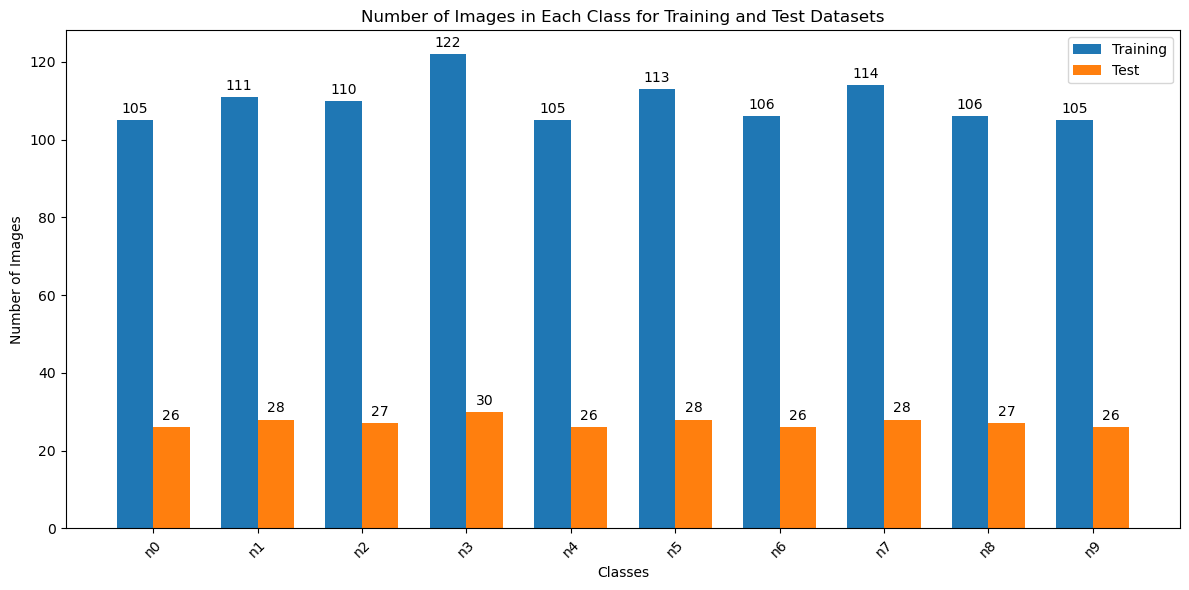

In [6]:
train_class_counts = Counter([label for _, label in train_dataset.imgs])
test_class_counts = Counter([label for _, label in test_dataset.imgs])

class_names = train_dataset.classes

train_counts = [train_class_counts[i] for i in range(len(class_names))]
test_counts = [test_class_counts[i] for i in range(len(class_names))]

x = np.arange(len(class_names))
width = 0.35 

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, train_counts, width, label='Training')
rects2 = ax.bar(x + width/2, test_counts, width, label='Test')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Each Class for Training and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Displaying Transformed Images
- Visualize a few transformed images to ensure the preprocessing pipeline is working as expected.
- Display the transformations like resizing, flipping, or normalization visually for validation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0856657..3.2924516].


labels:  tensor([7, 3, 7, 1, 1, 4])


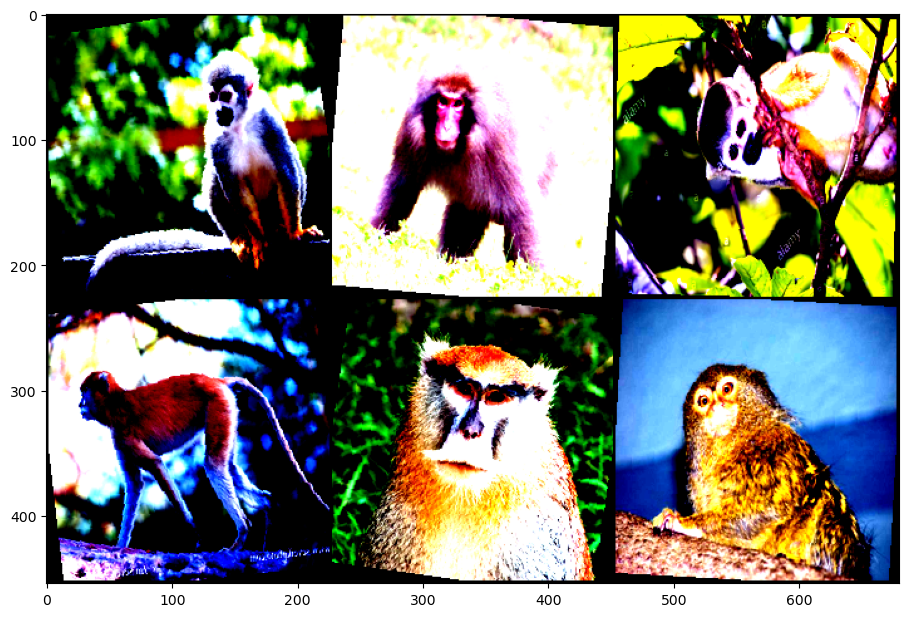

In [7]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print( "labels: " , labels)
    
show_transformed_images(train_dataset)

### Data Loaders
- Create data loaders for efficient batch processing during training and testing.
- Set batch sizes( =32 ) and shuffle the training data for better learning.


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# MODEL TRAINING

**This cell imports essential PyTorch modules:**

- `torchvision.models`: Predefined model architectures.
- `torch.nn`: Neural network components like loss functions and layers.
- `torch.optim`: Optimization algorithms.
- `torchvision.models.ResNet18_weights`: Pretrained weights for the ResNet-18 model.

In [9]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights

Defines a function to check if a CUDA-enabled GPU is available and sets the appropriate device (`cuda` or `cpu`) for model training.

In [10]:
def set_device():
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    return torch.device(device)

### Model Initialization
- Load the ResNet-18 model pre-trained on ImageNet.
- Replace the fully connected layer with a custom layer to match the number of classes in the dataset.


In [11]:
resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10

resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_function = nn.CrossEntropyLoss()


### Optimizer
- Use SGD (Stochastic Gradient Descent) with momentum and weight decay for optimization.
- Define the loss function as CrossEntropyLoss, suitable for classification tasks.

In [12]:

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

### Visualizing Initial Filters
- Display the filters of the first convolutional layer in the ResNet-18 model.
- Helps understand how the model processes the input imag

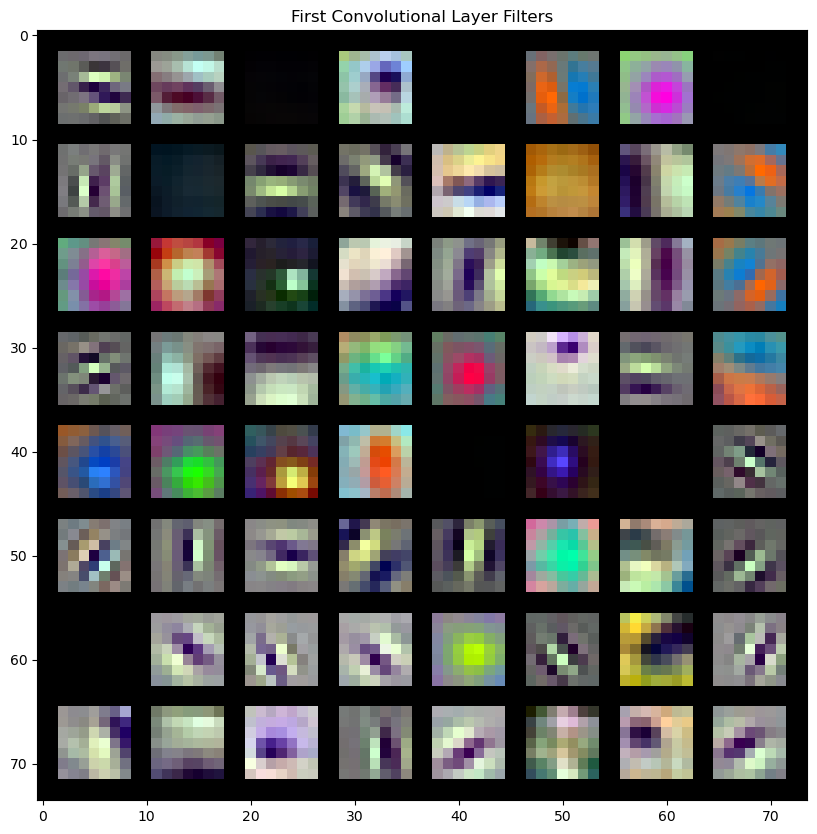

In [13]:

def visualize_filters(model):
    filters = model.conv1.weight.data.cpu()
    grid = torchvision.utils.make_grid(filters, normalize=True, scale_each=True, nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("First Convolutional Layer Filters")
    plt.show()
    
visualize_filters(resnet18_model)

### Training the Model
- Define a training function `train_nn` that:
  - Trains the model for multiple epochs.
  - Tracks metrics like loss and accuracy.
  - Saves the best model checkpoint based on validation accuracy.
- Use the defined function to train the model for 20 epochs.


**Initializes a dictionary to store training and evaluation metrics:**

- `train_loss`: Training loss for each epoch.
- `train_acc`: Training accuracy for each epoch.
- `test_acc`: Test accuracy for each epoch.

In [14]:
training_metrics = {
    "train_loss": [],
    "train_acc": [],
    "test_acc": []
}

**Evaluates the Model on the Test Set**

- Switches the model to evaluation mode using `model.eval()`.
- Prevents gradient computation for efficiency using `torch.no_grad()`.
- Calculates and prints the test accuracy.

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    predicted_correctly = 0
    total = 0
    device =set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly += (predicted == labels).sum().item()
            
    epoch_acc = 100 * predicted_correctly / total
    
    print(f" - Test dataset. got {predicted_correctly} out of {total} images correctly")
    print(f"Accuracy: {epoch_acc:.4f}%")
    
    return epoch_acc

**Saving the Model Checkpoint**

- Stores the model's state dictionary, optimizer state, epoch number, and best accuracy.
- Saves the checkpoint as a `.pth.tar` file for reproducibility and deployment.

In [16]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc,
        'comments': "best model"
    }
    
    torch.save(state, "best_model_checkpoint.pth.tar")

**Trains the model over a specified number of epochs:**
- Switches the model to training mode using `model.train()`.
- Iterates through the `train_loader`, calculates the loss and accuracy, and updates weights using backpropagation.
- Evaluates the model on the test set after each epoch and stores metrics.
- Saves the model if it achieves the best accuracy so far.


In [17]:

def train_nn(model, train_loader, teste_loader, criterion, optimizer , n_epochs):
    device = set_device()
    best_acc = 0.0
    
    for epoch in range(n_epochs):
        print(f"-------------------------------\nEpoch {epoch + 1}\n-------------------------------")
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _ , predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_corrects += (predicted == labels).sum().item()
            
        epoch_loss = running_loss/ len(train_loader)
        epoch_acc = 100 * running_corrects / total
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}%")

        print(f" - Training dataset. got {running_corrects} out of {total} images correctly")
        
        test_acc = evaluate_model(model, test_loader)
        training_metrics["train_loss"].append(epoch_loss)
        training_metrics["train_acc"].append(epoch_acc)
        training_metrics["test_acc"].append(test_acc)
        
        
        if test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
            
        
    print("Finished Training")
    return model

In [18]:
train_nn(resnet18_model, train_loader, test_loader, loss_function, optimizer, 20)

-------------------------------
Epoch 1
-------------------------------
Loss: 0.6508 Acc: 79.6718%
 - Training dataset. got 874 out of 1097 images correctly
 - Test dataset. got 247 out of 272 images correctly
Accuracy: 90.8088%
-------------------------------
Epoch 2
-------------------------------
Loss: 0.1183 Acc: 96.3537%
 - Training dataset. got 1057 out of 1097 images correctly
 - Test dataset. got 255 out of 272 images correctly
Accuracy: 93.7500%
-------------------------------
Epoch 3
-------------------------------
Loss: 0.0688 Acc: 97.6299%
 - Training dataset. got 1071 out of 1097 images correctly
 - Test dataset. got 261 out of 272 images correctly
Accuracy: 95.9559%
-------------------------------
Epoch 4
-------------------------------
Loss: 0.0478 Acc: 98.9061%
 - Training dataset. got 1085 out of 1097 images correctly
 - Test dataset. got 266 out of 272 images correctly
Accuracy: 97.7941%
-------------------------------
Epoch 5
-------------------------------
Loss: 0.0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# EVALUATION

### Training Metrics
- Visualize the training loss and accuracy over epochs.
- Compare with validation accuracy to check for overfitting or underfitting.


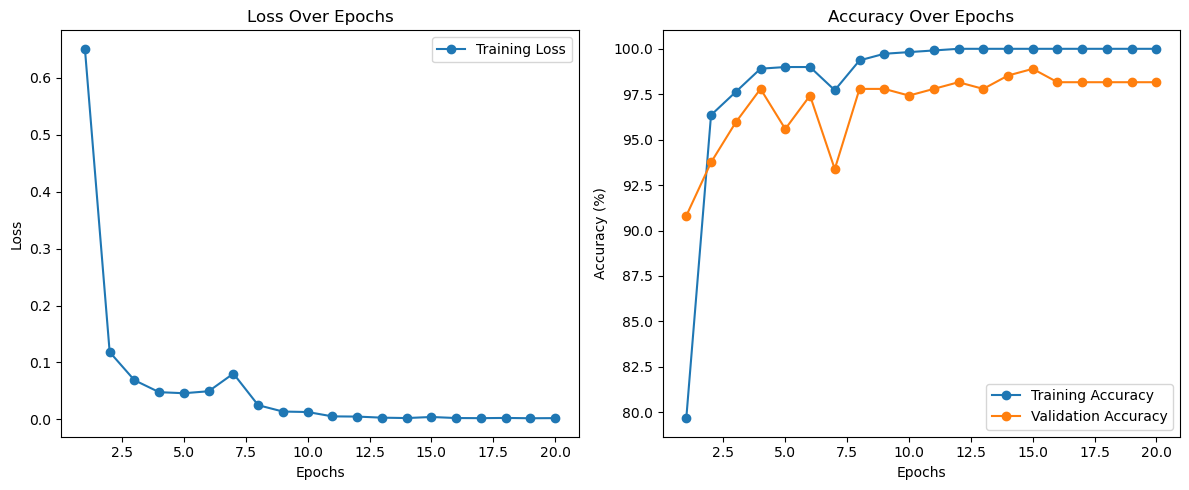

In [19]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_acc"], label="Training Accuracy", marker="o")
    
    # Filter out None values in test_acc
    valid_epochs = [e for e, acc in zip(epochs, metrics["test_acc"]) if acc is not None]
    valid_test_acc = [acc for acc in metrics["test_acc"] if acc is not None]
    plt.plot(valid_epochs, valid_test_acc, label="Validation Accuracy", marker="o")
    
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
plot_metrics(training_metrics)

### Model Evaluation
- Define functions for evaluating model performance:
  - `evaluate_model`: Calculates accuracy on the test dataset.
  - `plot_confusion_matrix`: Displays the confusion matrix for class-wise predictions.
  - `classwise_accuracy`: Reports accuracy for each class individually.


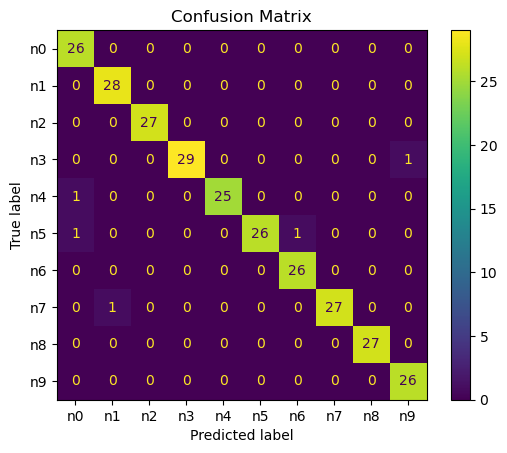

In [20]:
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="viridis")
    plt.title("Confusion Matrix")
    plt.show()

class_names = train_dataset.classes
plot_confusion_matrix(resnet18_model, test_loader, class_names)

In [21]:
def classwise_accuracy(model, test_loader, class_names):
    model.eval()
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                label = labels[i]
                if predicted[i] == label:
                    class_correct[label] += 1
                class_total[label] += 1

    for i in range(len(class_names)):
        print(f"Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

classwise_accuracy(resnet18_model, test_loader, class_names)

Accuracy of n0: 100.00%
Accuracy of n1: 100.00%
Accuracy of n2: 100.00%
Accuracy of n3: 96.67%
Accuracy of n4: 96.15%
Accuracy of n5: 92.86%
Accuracy of n6: 100.00%
Accuracy of n7: 96.43%
Accuracy of n8: 100.00%
Accuracy of n9: 100.00%


**Generating Classification Report**

To evaluate the performance of the trained ResNet-18 model, a classification report is generated. This report includes metrics such as **precision**, **recall**, **F1-score**, and **support** for each class. The report provides a detailed breakdown of how well the model performs for each category in the dataset.

In [22]:
def generate_classification_report(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_predictions = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("Classification Report:\n")
    print(report)
    return report

generate_classification_report(resnet18_model, test_loader, class_names)

Classification Report:

              precision    recall  f1-score   support

          n0       0.93      1.00      0.96        26
          n1       0.97      1.00      0.98        28
          n2       1.00      1.00      1.00        27
          n3       1.00      0.97      0.98        30
          n4       1.00      0.96      0.98        26
          n5       1.00      0.93      0.96        28
          n6       0.96      1.00      0.98        26
          n7       1.00      0.96      0.98        28
          n8       1.00      1.00      1.00        27
          n9       0.96      1.00      0.98        26

    accuracy                           0.98       272
   macro avg       0.98      0.98      0.98       272
weighted avg       0.98      0.98      0.98       272



'              precision    recall  f1-score   support\n\n          n0       0.93      1.00      0.96        26\n          n1       0.97      1.00      0.98        28\n          n2       1.00      1.00      1.00        27\n          n3       1.00      0.97      0.98        30\n          n4       1.00      0.96      0.98        26\n          n5       1.00      0.93      0.96        28\n          n6       0.96      1.00      0.98        26\n          n7       1.00      0.96      0.98        28\n          n8       1.00      1.00      1.00        27\n          n9       0.96      1.00      0.98        26\n\n    accuracy                           0.98       272\n   macro avg       0.98      0.98      0.98       272\nweighted avg       0.98      0.98      0.98       272\n'

# MODEL CHECKPOINTING

### Saving and Loading Checkpoints
- Save the best model checkpoint during training.
- Reload the model from the checkpoint for future inference or further training.


In [23]:
# Loading the best model checkpoint
checkpoint = torch.load("best_model_checkpoint.pth.tar")

# Extracting and printing the best accuracy, comments, and epoch from the checkpoint
best_acc = checkpoint['best_acc']
comments = checkpoint['comments']
epoch = checkpoint['epoch']

print(f"Best Accuracy: {best_acc}")
print(f"Comments: {comments}")
print(f"Epoch: {epoch}")

Best Accuracy: 98.8970588235294
Comments: best model
Epoch: 15


C:\Users\asus\AppData\Local\Temp\ipykernel_19676\1742079192.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_checkpoint.pth.tar")


### Saving the Final Model
- Save the trained ResNet-18 model to a `.pth` file for deployment or inference.
- Ensure the model includes the custom fully connected layer for the classification task.


In [24]:
resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')


# Conclusion

In this project, we successfully built and trained an image classification model using the ResNet-18 architecture. By leveraging the power of pre-trained deep learning models and applying techniques like data augmentation and normalization, we were able to improve the model's generalization and performance on the monkey image dataset. 

Key outcomes from the project include:

- **Model Performance**: The ResNet-18 model was able to achieve high accuracy on the test dataset, demonstrating its effectiveness in classifying images into their respective categories.
- **Training Process**: The model was trained using mini-batch gradient descent, with careful monitoring of the loss and accuracy to ensure consistent improvements.
- **Checkpointing**: We utilized checkpointing to save the best performing model based on validation accuracy, ensuring that the highest-performing model was used for final evaluation.
- **Final Model**: The best model was saved and is now ready for deployment or further fine-tuning with different datasets or architectures.

While the model performed well, there are still areas for future improvement. Possible directions include experimenting with deeper models such as ResNet-50 or ResNet-101, applying more advanced data augmentation techniques, or fine-tuning the learning rate and other hyperparameters to optimize performance further.

Overall, the project demonstrated the power of deep learning for image classification tasks and highlighted the importance of data preprocessing, model selection, and evaluation in achieving high-quality results.


---
---


The following code displays a run through if we do not use the pre-trained model weights. The code is commented out as we are using the pre-trained model weights.

It will need more than 200 epochs to train the model from scratch which will take a lot of time. Hence, we are using the pre-trained model weights.



In [25]:
'''
resnet18_model = models.resnet18(weights=None)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10

resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

train_nn(resnet18_model, train_loader, test_loader, loss_function, optimizer, 200)
'''

'\nresnet18_model = models.resnet18(weights=None)\nnum_ftrs = resnet18_model.fc.in_features\nnumber_of_classes = 10\n\nresnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)\ndevice = set_device()\nresnet18_model = resnet18_model.to(device)\nloss_function = nn.CrossEntropyLoss()\n\noptimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)\n\ntrain_nn(resnet18_model, train_loader, test_loader, loss_function, optimizer, 200)\n'

---
---

# USAGE OF SAVED MODEL

***please note the following section of code in completely out of scope of the assigment, it was just added to display the capablities of the model and a walkthrough on how to classify a single image from any source***

---

In the following code we will display how the saved model can be loaded and used for inference later. We will load the best model saved earlier ( by the checkpointing process ) by the name `best_model.pth`, and will us it to classify some set of test images, downloaded from google.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL.Image as Image
import os

In [4]:
classes =[ 'Mantled Howler', 'Patas Monkey', 'Bald Uakari', 'Japanese Macaque', 'Pygmy Marmoset', 'White Headed Capuchin', 'Silvery Marmoset', 'Common Squirrel Monkey', 'Black Headed Night Monkey', 'Nilgiri Langur']

model = torch.load('best_model.pth')

mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2038]

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

def classify(model, image_transforms, image_path, classes):
    model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    
    output = model(image)
    _ , pred = torch.max(output.data, 1)
    
    print(classes[pred.item()])
    
checking_imgs = os.listdir(path='./Model_check_imgs')

for img in checking_imgs:
    print(f"Image name: {img}")
    classify(model, image_transforms, f"./Model_check_imgs/{img}", classes)
    print("\n")

Image name: indian mac.jpg
Japanese Macaque


Image name: japanese_macaque.jpg
Japanese Macaque


Image name: Mantled Howler.jpg
Mantled Howler


Image name: Nilgiri Langur.jpg
Nilgiri Langur




C:\Users\asus\AppData\Local\Temp\ipykernel_27476\4130388394.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


---
---

#### ***Foot notes:***
*The complete code is also available on my GitHub repository, and can be downloaded from there* [HERE](https://github.com/justAbhinav/Image-Classification-model-powered-ResNET18)

---